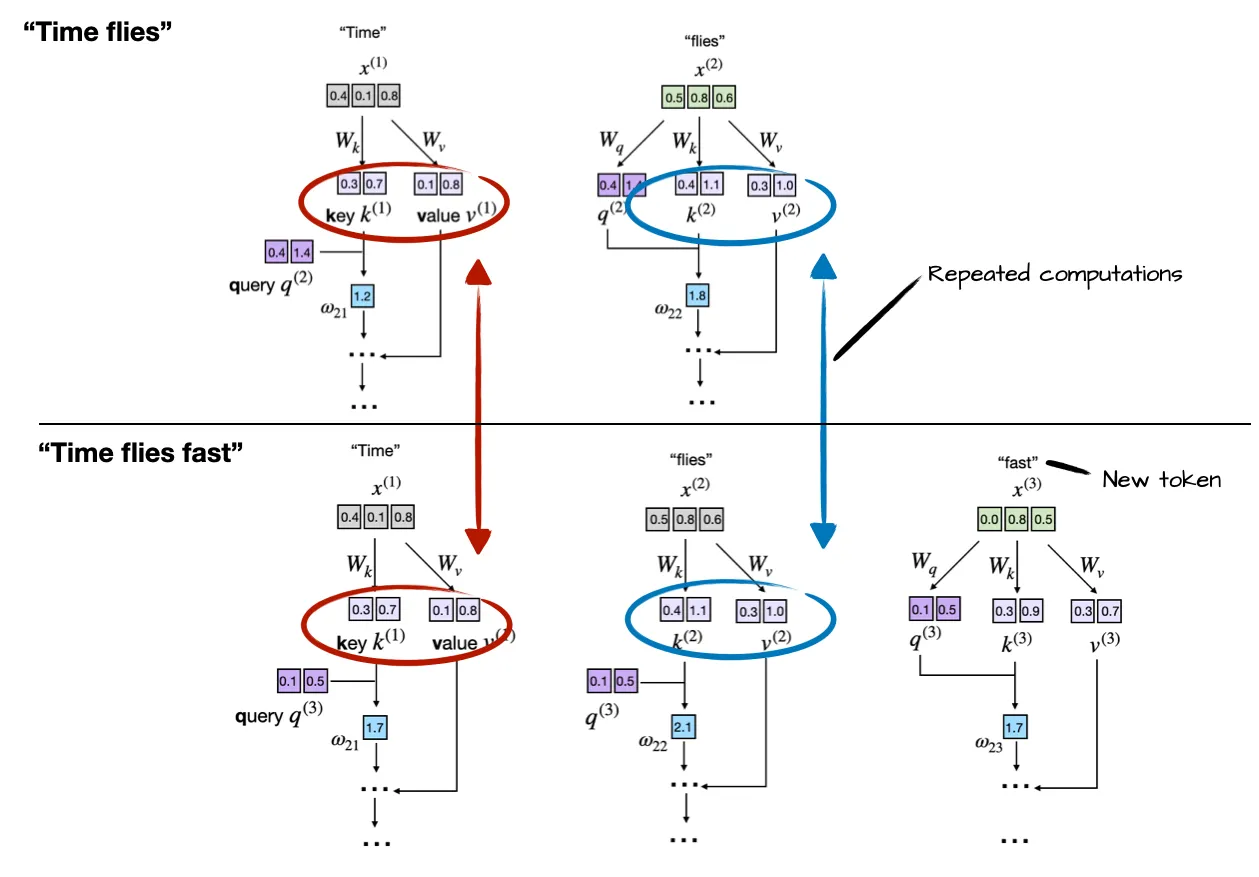

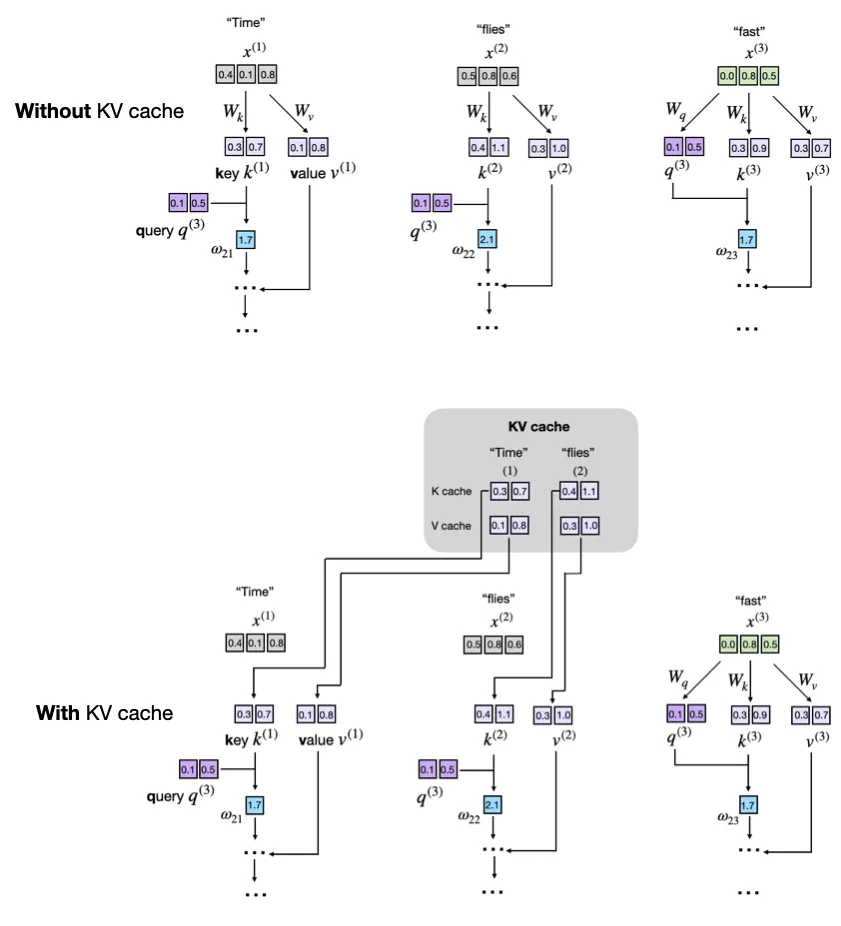

In [ ]:
import time 
import tiktoken
import torch
import torch.nn as nn

Chapter-3 Improvement for KV Cache

###################################
        # NEW
        self.register_buffer("cache_k", None, persistent=False)   
        self.register_buffer("cache_v", None, persistence=False)   
        self.ptr_current_pos = 0 
################################### 

Explaination -> 

"Hey, I'm going to use self.cache_k and self.cache_v to store some data. Please make sure they always move to whatever device (CPU or GPU) the rest of the model is on. However, do not save their contents when I save the model, because they are just temporary cache data."

( self.ptr_current_pos = 0 ) -> This Line initializes an index pointer to track the current fill-level of the KC cache ot tracks the current token position.

####################################################
        # NEW
        num_tokens_Q = queries.shape[-2]
        num_tokens_K = keys.shape[-2]
        if use_cache:
            mask_bool = self.mask.bool()[
                self.ptr_current_pos:self.ptr_current_pos + num_tokens_Q, :num_tokens_K
            ]
            self.ptr_current_pos += num_tokens_Q
####################################################

Explaination -> 

Normally (use_cache=False), both Q and K come from the same sequence (say length L), so we just take a square mask of shape [L, L].

When caching:

Keys are longer than queries (past + new tokens).

We slice the mask such that:

Rows: current query positions.

Columns: all key positions so far.

Then we increment ptr_current_pos to track how far we’ve generated.

This ensures causality — the new token only attends to past and itself, not future. 

In [ ]:
#####################
# Chapter 3
#####################

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer = ("mask",torch.triu(torch.ones(context_length, context_length), diagonal=1)) #self.mask

        ###################################
        # NEW
        self.register_buffer("cache_k", None, persistent=False)   
        self.register_buffer("cache_v", None, persistence=False)   
        self.ptr_current_pos = 0 
        ###################################

    def forward(self, x, use_cache=False):
        b, num_tokens, d_in = x.shape

        keys_new = self.W_key(x)
        queries = self.W_query(x)
        values_new = self.W_value(x)

        keys_new = keys_new.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values_new = values_new.view(b, num_tokens, self.num_heads, self.head_dim)

        ###################################
        #NEW
        if use_cache:
            if self.cache_k is None:
                self.cache_k, self.cache_v = keys_new, values_new
            else:
                self.cache_k = torch.cat([self.cache_k, keys_new], dim=-1)
                self.cache_v = torch.cat([self.cache_v, values_new], dim=-1)
            keys, values = self.cache_k, self.cache_v
        else:
            keys, values = keys_new, values_new
        ###################################

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attn_scores = queries @ keys.transpose(2, 3) 

        ###################################
        #NEW 
        num_tokens_Q = queries.shape[-2]      # number of new tokens (often=1 during generation)
        num_tokens_K = keys.shape[-2]         # number of total tokens so far (past + new)

        if use_cache:
            mask_bool = self.mask.bool()[
                self.ptr_current_pos:self.ptr_current_pos + num_tokens_Q, :num_tokens_K
            ]
            self.ptr_current_pos += num_tokens_Q
        ###################################

        # Original mask truncated to the number of tokens and converted to boolean
        else:
            mask_bool = self.mask.bool()[:num_tokens_Q, :num_tokens_K]

        # Use the mask to fill the attention score
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        d_k = keys.shape[-1]

        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1,2) 
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) 

        context_vec = self.out_proj(context_vec) 

        return context_vec
    
    ##############################
    #NEW
    def reset_cache(self):
        self.cache_k, self.cache_v = None, None
        self.ptr_current_pos = 0
    ##############################


Every Trasformer Block has its own version of self attention , so each block needs to remember its own K/V history.

Thats why the caching logic is inside the attention layer,
thats why 

####################################
#NEW
x = self.att(x, use_cache=True)
####################################

this flag just activates it at the block level

and also in this code 

##############################
#NEW
      def reset_cache(self):
        self.cache_k, self.cache_v = None, None
        self.ptr_current_pos = 0
##############################

before starting a new generation: we call reset_cache() on every attention layer in every transformer block 

nn.Sequential -> runs layers as one pipeline without manual control 
nn.ModuleList -> gives you explicit control to loop over one by one 

thats why in this code

####################################################
#NEW
self.trf_blocks = nn.ModuleList(
        [TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

self.current_pos = 0
####################################################

we used nn.ModuleList rather then nn.Sequential, because we must pass use_cache=True to each layer (or each transformer block) individually.

with nn.Sequential you cant easily pass extra arguments like use_cache to each layer. nn.ModuleList gives that flexibility.

also this line 

self.current_pos = 0 

tracks the current token position in the context window across the sequence generation 

In [ ]:
#############################
# Chapter 4
#############################

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)

        # x = self.att(x)
        ####################################
        #NEW
        x = self.att(x, use_cache=True)
        ####################################

        x = self.drop_shortcut(x)
        x = x + shortcut 

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        return x 
    
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        #self.trf_blocks = nn.Sequential(
        #    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        ##########################################
        #NEW
        self.trf_blocks = nn.ModuleList(
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.current_pos = 0                                        
        ##########################################

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx, use_cache=False):
        batch_size, seq_len = in_idx.shape 
        tok_embeds = self.tok_emb(in_idx)
        # pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        ##########################################
        #NEW
        if use_cache:
            pos_ids = torch.arange(self.current_pos, self.current_pos + seq_len, device=in_idx.device, dtype=torch.long)
            self.current_pos += seq_len

        else:
            pos_ids = torch.arange(0, seq_len, device=in_idx.device, dtype=torch.long)

        pos_embeds = self.pos_emb(pos_ids).unsequeeze(0)
        ##########################################
        
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        # x = self.trf_blocks(x)

        ###########################################
        #NEW
        for block in self.trf_blocks:
            x = block(x, use_cache=use_cache)
        ###########################################

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
    ##########################################
    #NEW
    def reset_kv_cache(self):
        for block in self.trf_blocks:
            block.att.reset_cache()
        self.current_pos = 0
    ##########################################
    
def generate_text_simple(model, idx, max_new_tokens, context_size):
    model.eval()
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        idx_next = torch.argmax(logits, dim=-1, keepdim=True) 

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

######################################
#NEW
def generate_text_simple_cached(model, idx, max_new_tokens,
                                context_size=None, use_cache=True):
    model.eval()  # this puts the model in evaulation mode (turns off dropout)
    ctx_len = context_size or model


In [ ]:
def main():
    GPT_CONFIG_124M = {
        "vocab_size": 50257,
    }